In [24]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Jeu de données d'apprentissage

### Créer un Dataset personnalisé

In [25]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = F.one_hot(torch.tensor(label), num_classes=12).squeeze().to(torch.float32)
        return image, label

### Charger les données du fichier texte

In [26]:
class AlphaChannelRemoval(object):
    def __call__(self, img):
        if img.mode == 'RGBA':
            img = img.convert('RGB')
        return img

In [27]:
class ResizeWithBackground(object):
    def __init__(self, size, background_color=(0, 0, 0)):
        self.size = size
        self.background_color = background_color

    def __call__(self, image):
        width, height = image.size

        if width > self.size[0] or height > self.size[1]:
            target_aspect_ratio = self.size[1] / self.size[0]
            dh = height - self.size[1]
            dw = width - self.size[0]

            if dh>dw:
                new_height = int(self.size[1])
                new_width = int(new_height/target_aspect_ratio)
            else:
                new_width = int(self.size[0])
                new_height = int(new_width*target_aspect_ratio)

            resized_image = image.resize((new_width, new_height), resample=Image.LANCZOS)

            x = 0
            y = 0

            background = Image.new("RGB", self.size, self.background_color)
            background.paste(resized_image, (x, y))

            return background
        else:
            background = Image.new("RGB", self.size, self.background_color)
            background.paste(image, (0, 0))
            return background

In [28]:
with open("train/image_list.txt", 'r') as f:
    lines = f.readlines()

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    image_paths.append("train/" + line[0])
    labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transform = transforms.Compose([
    AlphaChannelRemoval(),
    ResizeWithBackground((384,216)),
    transforms.ToTensor()
])

### Fonction pour avoir 4 images du dataframe

In [29]:
def extrait(loader):
    images, labels = next(iter(loader))

    # Afficher les premières images du batch
    num_images_to_display = 4
    fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 3))
    for i in range(num_images_to_display):
        image = images[i]
        label = labels[i]

        # Convertir l'image en ndarray et inverser la normalisation
        img_np = image.numpy()
        img_np = img_np.transpose((1, 2, 0))
        img_np = img_np * 0.5 + 0.5

        # Afficher l'image avec l'étiquette correspondante
        axes[i].imshow(img_np)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

### Créer un DataLoader pour charger les données par lots

In [30]:
batch_size = 64
df_train = CustomDataset(image_paths, labels, transform=transform)
trainloader = DataLoader(df_train, batch_size=batch_size, shuffle=True)

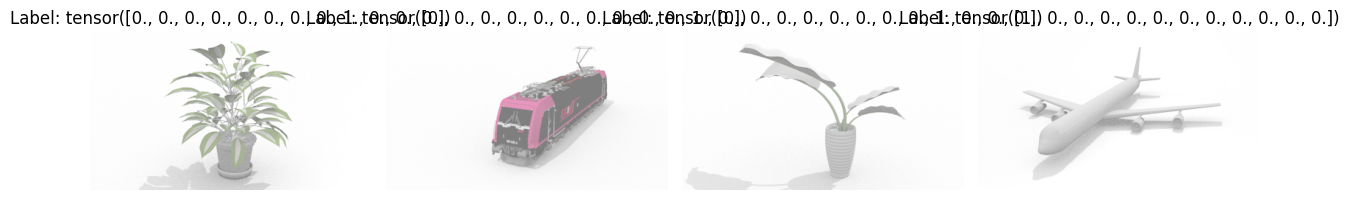

In [31]:
extrait(trainloader)

### Afficher une grille des images avec les différents labels

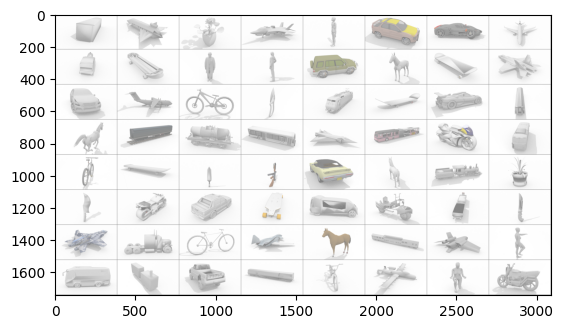

torch.Size([64, 3, 216, 384])


In [32]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0))) #Cette ligne utilise la fonction plt.imshow de Matplotlib pour afficher 
  #l'image. np.transpose(npimg, (1, 2, 0)) transpose les dimensions de l'array NumPy npimg 
  #pour qu'elles correspondent au format attendu par imshow (largeur x hauteur x canaux).
  plt.show()
# Charger le premier batch d'images et d'étiquettes
images, labels = next(iter(trainloader))

# Afficher la grille des images
imshow(torchvision.utils.make_grid(images))
print(images.size())

### Normalisation

In [10]:
mean_accumulator = 0.0
std_accumulator = 0.0
total_batches = 0

for images, _ in trainloader:

    # Calculer les valeurs moyennes et les écarts types pour le batch courant
    batch_mean = torch.mean(images, dim=(0, 2, 3))
    batch_std = torch.std(images, dim=(0, 2, 3))

    # Accumuler les statistiques pour tous les batches
    mean_accumulator += batch_mean
    std_accumulator += batch_std
    total_batches += 1

# Calculer les moyennes et les écarts types globaux
mean = mean_accumulator / total_batches
std = std_accumulator / total_batches

print("Mean:", mean)
print("Std:", std)


Mean: tensor([0.8869, 0.8856, 0.8831])
Std: tensor([0.1999, 0.2032, 0.2101])


In [33]:
with open("train/image_list.txt", 'r') as f:
    lines = f.readlines()

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    image_paths.append("train/" + line[0])
    labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transformation = transforms.Compose([
    AlphaChannelRemoval(),
    ResizeWithBackground((384,216)),
    transforms.ToTensor(),
    transforms.Normalize((0.8869, 0.8856, 0.8831),(0.1999, 0.2032, 0.2101))
])


In [34]:

df_train = CustomDataset(image_paths, labels, transform=transformation)
trainloader = DataLoader(df_train, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


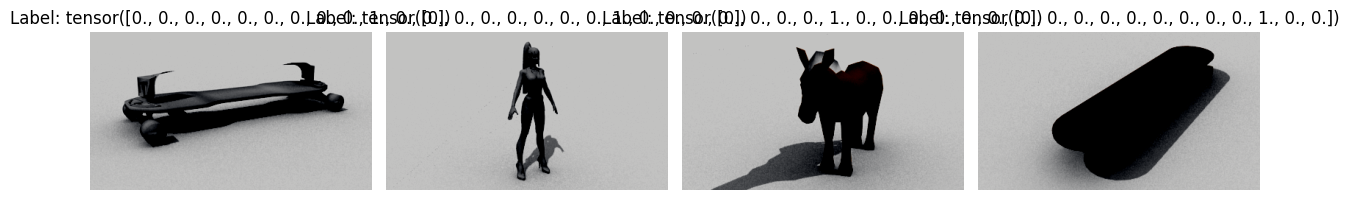

In [35]:

extrait(trainloader)

#Les images normalisées sont hors de la plage de pixel pour matplotlib

In [36]:
images, _ = next(iter(trainloader))

# Calculer la moyenne et l'écart-type des images
mean = torch.mean(images, dim=(0, 2, 3))
std = torch.std(images, dim=(0, 2, 3))

print("Mean:", mean)
print("Std:", std)

Mean: tensor([-0.0157,  0.0011,  0.0011])
Std: tensor([1.0170, 0.9790, 0.9801])


### Flatten

In [37]:
with open("train/image_list.txt", 'r') as f:
    lines = f.readlines()

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    image_paths.append("train/" + line[0])
    labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transform_train = transforms.Compose([
    AlphaChannelRemoval(),
    ResizeWithBackground((384,216)),
    transforms.ToTensor(),
    transforms.Normalize((0.8869, 0.8856, 0.8831),(0.1999, 0.2032, 0.2101)),
    transforms.Lambda(lambda x: torch.flatten(x))
])


In [38]:
df_train = CustomDataset(image_paths, labels, transform=transform_train)
trainloader = DataLoader(df_train, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


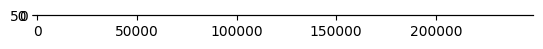

torch.Size([64, 248832])


In [39]:
images, labels = next(iter(trainloader))

# Afficher la grille des images
imshow(torchvision.utils.make_grid(images))
print(images.size())

# Modèle linéaire

### Paramétrage du modèle

In [263]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=3*216*384, output_dim=12):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
          x = x.view(x.size(0), -1)
          x = self.linear(x)
          return x

In [264]:
device = torch.device("mps")
model  = LinearClassifier().to(device)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

### Entraînement du modèle

In [92]:
all_loss = []
for epoch in range(50):
    temp_loss = []
    for images, labels in trainloader:
        images = images.to(device)  # déplacer les images sur le dispositif
        labels = labels.to(device)
        # Réinitialiser les gradients
        optimizer.zero_grad()
        # Calculer les sorties du modèle
        output = model(images)
        # Calculer la perte en utilisant les sorties et les étiquettes
        loss = criterion(output, labels)
        # Rétropropagation et mise à jour des poids
        loss.backward()
        optimizer.step()

        temp_loss.append(loss.item())

    all_loss.append(torch.mean(torch.tensor(temp_loss), dim=0).item())
    print(f"Epoch: {epoch}, loss: {np.mean(temp_loss)}")


KeyboardInterrupt: 

### Fonction de perte

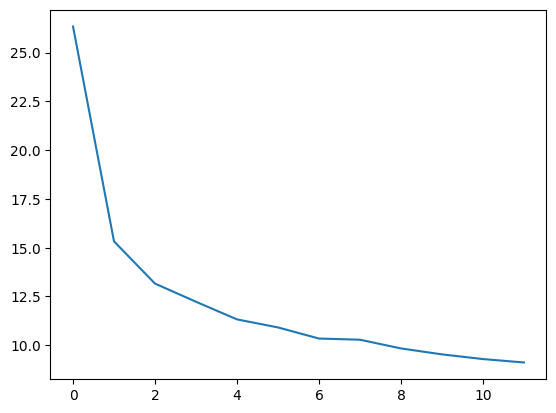

In [ ]:
plt.plot(all_loss)

# Jeu de données de test

### Charger les données du fichier texte

In [394]:
with open("test/image_list.txt", 'r') as f:
    lines = f.readlines()

# Créer des listes pour stocker les chemins d'image et les étiquettes
image_paths = []
labels = []

# Parcourir chaque ligne du fichier texte et extraire les informations
for line in lines:
    line = line.strip().split(' ')
    image_paths.append("test/" + line[0])
    labels.append(int(line[1]))

# Appliquer les transformations d'image si nécessaire
transform = transforms.Compose([
    AlphaChannelRemoval(),
    ResizeWithBackground((384,216)),
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: torch.flatten(x))
])

### Créer un DataLoader pour charger les données par lots

In [395]:
batch_size = 64
df_test = CustomDataset(image_paths, labels, transform=transform)
testloader = DataLoader(df_test, batch_size=batch_size, shuffle=True)

### Afficher la grille des images

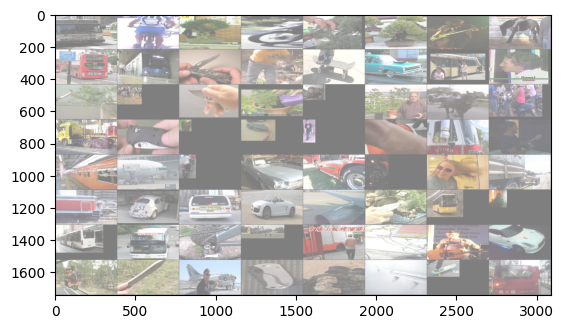

torch.Size([64, 3, 216, 384])


In [396]:
# Charger le premier batch d'images et d'étiquettes
images, labels = next(iter(testloader))

# Afficher la grille des images
imshow(torchvision.utils.make_grid(images))
print(images.size())

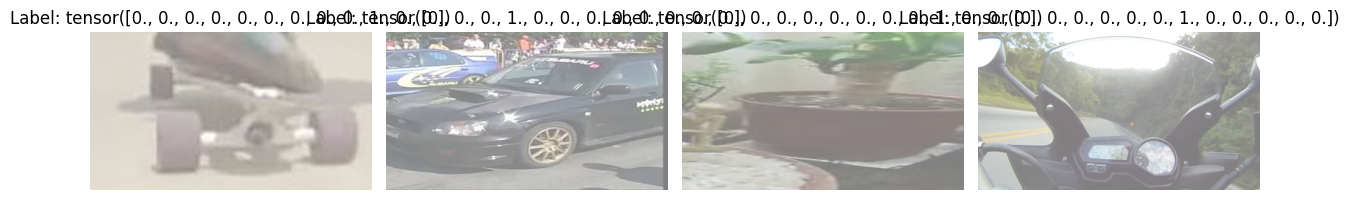

In [392]:
extrait(testloader)

# Précison du modèle

In [ ]:
correct, total = 0, 0

with torch.no_grad():

  for images, labels in testloader:
    output = model(images.view(images.shape[0], -1))

    _, predicted = torch.max(output.data, 1)
    # le _ permet de ne pas prendre en compte le score maximal calculé mais seulement l'indice
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

In [ ]:
100 * correct / total

5.014370198419278